# Aprendizaje Automatico - Diplodatos 2022
Trabajo Práctico MLP 

In [1]:
integrantes = ["Maria Virginia Romero Messein", "Diana Carolina Fonnegra Mora"]
print('Integrantes: \n ',*integrantes, sep="\n")

Integrantes: 
 
Maria Virginia Romero Messein
Diana Carolina Fonnegra Mora


# Notebook 2 
En este práctico trabajaremos en el problema de clasificación de texto del MeLi Challenge 2019

El datasets tiene información acerca de títulos de publicaciones, categoría de los mismos, información de idioma y confiabilidad de la anotación. Cuenta con anotaciones de títulos para 632 categorías distintas.

El dataset también cuenta con una partición de test que está compuesta de 63680 de ejemplos con las mismas categorías (aunque no necesariamente la misma distribución).



# Resultados del práctico 2:
Para la resolución de las tareas propuestas realizamos los siguientes pasos. Primero definimos las librerías necesarias:



In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, IterableDataset

from gensim import corpora
from gensim.parsing import preprocessing
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

import tqdm
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors

import csv
import functools
import gzip
import numpy as np
import pandas as pd
import tempfile
import json
import mlflow

In [3]:
# # confirmamos la version de pytorch:
# torch.__version__

Para la descarga de la información usamos:

In [4]:
# #Los datos fueron cargados la primera vez que se ejecutó este bloque de código, por este motivo el código está comentado
# !mkdir ./data
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
# !tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
# !pip install mlflow


In [5]:
# !wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2

In [6]:
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/SBW-vectors-300-min5.txt.bz2 -o ./data/SBW-vectors-300-min5.txt.bz2
# !tar -xf ./data/SBW-vectors-300-min5.txt.bz2 -C ./data/

### Analizamos el contenido y distribución
Leemos el conjunto de datos fragmentado:

In [ ]:
# Definimos el conjunto de datos de entrenamiento / Formato Json a Dataframe:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz',\
                                              lines=True, chunksize=100000)], ignore_index=True)
train_df.head(3)

In [ ]:
# train_df

In [ ]:
train_df.info()

In [ ]:
# Definimos el conjunto de datos de test / Formato Json a Dataframe:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz',\
                                              lines=True, chunksize=100000)], ignore_index=True)
test_df.tail(3)
# train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz',\
#                                               lines=True, chunksize=100000)], ignore_index=True)
# pd.read_json("/content/data/meli-challenge-2019/spanish.validation.jsonl.gz",lines=True, orient='records')

In [ ]:
train_df.info()

In [ ]:
# Definimos el conjunto de datos de validacion / Formato Json a Dataframe:
valid_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz',\
                                             lines=True, chunksize=100000)], ignore_index=True)
valid_df.tail(3)

In [ ]:
# creando dos subdataset y dando información general: 
df_train = train_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos entrenamiento: {df_train.shape}, \n{df_train.head(3)}\n')
df_train.info()

In [ ]:
# Ahora con datos de prueba:
df_test = test_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos prueba: {df_test.shape}, \n{df_test.head(3)}\n')
df_test.info()

In [ ]:
df_test

In [ ]:
# creando dos subdataset y dando información general: 
val_df = valid_df.loc[:, ['category', 'title']]
print(f'Forma del conjunto de datos Validacion: {val_df.shape}, \n{val_df.head(3)}\n')
val_df.info()

In [ ]:
val_df.head()

Definimos las clases que seran útiles para el procesamiento del conjunto de datos:

In [ ]:
data = pd.concat([df_train,val_df,df_test], ignore_index=True)
data.head(3)

In [ ]:
data['category'].nunique()

# 632 posibles titulos

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt


conteo_tit_cat = data['category'].value_counts()


plt.figure(figsize=(20, 5))
conteo_tit_cat.sort_values()

En general podemos inferir que las categorias de entrada presentan un notorio desbalance. Esto puede ser una posible fuente de error que afecte el desarrollo de los modelos.

A continuacion formamos el procesador del conjunto de datos

In [ ]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
 #       self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        #### Cambio
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()

        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1 
        })
        #### Cambio
        
       
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [ ]:
class MelichanllegeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item
    
    

Pasamos a aplicar las clases definidas previamente para preprocesar ambos conjuntos:

In [ ]:
#Cambio! 

preprocess_train = RawDataProcessor(data)


In [ ]:
train_ds = MelichanllegeDataset(df_train, transform=preprocess_train)

test_ds = MelichanllegeDataset(df_test, transform=preprocess_train)

dev_ds = MelichanllegeDataset(val_df, transform=preprocess_train)

# Entrenamiento y test
print(f"Datasets loaded with {len(train_ds)} training elements and {len(test_ds)} test elements")
print(f"Sample train element:\n{train_ds[0]}")

Definimos el modulo Padsequences, recordando que este se define para tomar un valor mínimo y opcionalmente un valor máximo, así como un valor de relleno (pad) y una lista de secuencias. Este nos retornara un tensor con padding sobre dichas secuencias.

In [ ]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders
Aplicamos el modulo anterior y especificamos nuestros DataLoaders (uno para entrenamiento y otro para evaluación).

In [ ]:
EPOCHS = 5
FILTERS_COUNT = [100,100,100] #num_filters
FILTERS_LENGTH = [3, 4, 5] #filter_sizes

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))

train_loader = DataLoader(train_ds, batch_size=96, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)

dev_loader = DataLoader(dev_ds, batch_size=96, shuffle=True,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)


In [ ]:
test_loader = DataLoader(test_ds, batch_size=96, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Parte 2: Esqueleto de la red CNN
Definimos el modelo a entrenar.

In [ ]:
# Eligiendo dispositivo (se puede cambiar en notebook settings)
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda:0")
    print("GPU disponible")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

In [ ]:
import bz2
import os
import sys 

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score

## Experimento de MLflow

### CNN - Para texto:
Definimos el modelo a entrenar en nuestro caso usaremos

In [ ]:
class CNN(nn.Module):
    def __init__(self,  
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings=True,
                 num_filters=[100,100,100],
                 filter_sizes=[3, 4, 5], num_classes=632, dropout=0.5):
    
        
        super(CNN, self).__init__()
        
       
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
         
        self.convs = []
        for fs in range(len(filter_sizes)):
            self.convs.append(nn.Conv1d(vector_size,
                          num_filters[fs],
                          filter_sizes[fs])
            )
        self.convs = nn.ModuleList(self.convs)
        
        self.fc1 = nn.Linear(np.sum(num_filters), int(np.sum(num_filters) / 2))
        self.fc2 = nn.Linear(int(np.sum(num_filters) / 2), num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(num_classes, num_classes)
        
       

    
#     @staticmethod
#     def conv_global_max_pool(x, conv):
#         return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
#         transpose(1, 2)
        x_reshaped = self.embeddings(x).permute(0, 2, 1)  # Conv1d takes (batch, channel, seq_len)
#         [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.convs]
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        
        x_fc1 = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        x_fc2 = self.fc1(self.dropout(x_fc1))
        x = self.fc2(self.dropout(x_fc2))
#         print(x.shape,x.dtype)
        x = F.softmax(self.output_layer(x), 1)
        
        return x
    
    
    

Encapsularemos el algoritmo de entrenamiento dentro de una función parametrizable. La función debería devolver los resultados obtenidos.

In [33]:
from sklearn import metrics

mlflow.set_experiment("Experimento_3_CNN")

with mlflow.start_run():
    mlflow.log_param("model_name", "CNN")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
#         "fc_size": 100
    })
    
    cnn = CNN("./data/SBW-vectors-300-min5.txt.bz2",
              preprocess_train.dictionary, 
              vector_size=300,
              freeze_embedings=True,
              num_filters=[100,100,100],
              filter_sizes=[3, 4, 5],
              num_classes=632,
              dropout=0.5)
    
    cnn.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=0.01)
    
    historyCNN = {'val_loss': [],
               'train_loss': [],
               'total_accuracy': []
              }       
    
    
    for epoch in trange(EPOCHS):
        cnn.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long()
            labels = labels.to(device)
            
            
            outputs = cnn(inputs)

            loss_value = loss_function(outputs, labels)

            loss_value.backward()
            optimizer.step()
            
            running_loss.append(loss_value.item()) 
            
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        historyCNN['train_loss'].append(( sum(running_loss) / len(running_loss), epoch))
        
        cnn.eval()
        
        running_loss_dev = []
        targets = []
        predictions = []
        
        for i, data in enumerate(tqdm(dev_loader)):
            
            inputs_v = data["data"].to(device)
            labels_v = data["target"].squeeze().long()
            labels_v = labels_v.to(device)            
            output = cnn(inputs_v)
            
            running_loss_dev.append(loss_function(output, labels_v).item())
            _, predicted = torch.max(output.data, 1)
            
            targets.extend(labels_v.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
        mlflow.log_metric("val_loss", sum(running_loss_dev) / len(running_loss_dev), epoch)
        mlflow.log_metric("val_avp", balanced_accuracy_score(targets, predictions), epoch)
        
        historyCNN['val_loss'].append((sum(running_loss_dev) / len(running_loss_dev), epoch))
        historyCNN['total_accuracy'].append((balanced_accuracy_score(targets, predictions), epoch))
       
        print(f'Perdida-loss/validacion: {sum(running_loss_dev)/len(running_loss_dev)}')
        print(f'val_avp: {balanced_accuracy_score(targets, predictions)}')

                

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50993 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.448891149227878
val_avp: 0.0015822784810126582


  0%|          | 0/50993 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.448891106140183
val_avp: 0.0015822784810126582


  0%|          | 0/50993 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.448891138455954
val_avp: 0.0015822784810126582


In [34]:
# print(cnn)


CNN(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=632, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=632, out_features=632, bias=True)
)


In [ ]:
# historyCNN

In [36]:
# mlflow.search_runs()
# # runs = mlflow.search_runs()
# runs[runs.status == "FINISHED"]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.val_loss,metrics.val_avp,params.filters_length,params.filters_count,params.freeze_embedding,params.model_name,params.fc_size,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.source.type
0,c84c315fc117455cb7b8f535696b7406,6,FINISHED,file:///users/dfonnegra/mlruns/6/c84c315fc1174...,2022-11-11 00:06:46.177000+00:00,2022-11-11 00:48:57.387000+00:00,6.448891,6.448891,0.001582,"[3, 4, 5]","[100, 100, 100]",True,CNN,None,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,funny-bass-207,LOCAL
4,535d783cf93d4ba98248e909dd6d5d82,6,FINISHED,file:///users/dfonnegra/mlruns/6/535d783cf93d4...,2022-11-10 22:50:59.404000+00:00,2022-11-10 23:17:30.121000+00:00,6.448891,6.448891,0.001582,"[3, 4, 5]","[100, 100, 100]",True,CNN,None,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,suave-hare-243,LOCAL
5,00b3c710c87144d38f392f82ea225bf4,6,FINISHED,file:///users/dfonnegra/mlruns/6/00b3c710c8714...,2022-11-10 22:00:33.990000+00:00,2022-11-10 22:50:04.123000+00:00,6.448891,6.448891,0.001582,"[3, 4, 5]","[100, 100, 100]",True,CNN,None,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,polite-skunk-12,LOCAL
25,8235a004247f42d4910dc59b6b7500a0,6,FINISHED,file:///users/dfonnegra/mlruns/6/8235a004247f4...,2022-11-02 22:48:33.375000+00:00,2022-11-03 00:04:52.868000+00:00,0.000000,0.000000,0.001582,"[2, 3, 4]",100,True,CNN,100,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,fearless-moose-556,LOCAL
32,771ceaed6535429b97cc99d5e00d71c7,6,FINISHED,file:///users/dfonnegra/mlruns/6/771ceaed65354...,2022-11-02 18:07:46.090000+00:00,2022-11-02 19:38:39.829000+00:00,-31225.488365,-31225.731217,0.001582,"[2, 3, 4]",100,True,CNN,100,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,carefree-hen-512,LOCAL
38,b981782399394982ad4221e396292ed9,6,FINISHED,file:///users/dfonnegra/mlruns/6/b981782399394...,2022-11-02 16:50:43.381000+00:00,2022-11-02 17:31:38.797000+00:00,-31225.233430,-31225.671243,0.001582,"[2, 3, 4]",100,True,CNN,50,dfonnegra,/users/dfonnegra/miniconda3/envs/deeplearning/...,awesome-slug-429,LOCAL


# Resultados de las métricas
### Gráficos para  CNN

In [ ]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)


In [38]:
# data = []
# for epoch, (train_loss, val_loss) in enumerate(zip(
#         historyCNN['train_loss'], historyCNN['val_loss'])):
#     print((epoch, 'Entrenamiento', train_loss[0]))
#     print((epoch, 'Validación', val_loss[0]))
#     data.append((epoch, 'Entrenamiento', train_loss[0]))
#     data.append((epoch, 'Validación', val_loss[0]))
# data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'Loss'])

(0, 'Entrenamiento', 6.448891129105739)
(0, 'Validación', 6.448891149227878)
(1, 'Entrenamiento', 6.448891130770223)
(1, 'Validación', 6.448891106140183)
(2, 'Entrenamiento', 6.4488911301437035)
(2, 'Validación', 6.448891138455954)


In [39]:
# data

,Epoch,Conjunto,Loss
0,0,Entrenamiento,6.448891
1,0,Validación,6.448891
2,1,Entrenamiento,6.448891
3,1,Validación,6.448891
4,2,Entrenamiento,6.448891
5,2,Validación,6.448891


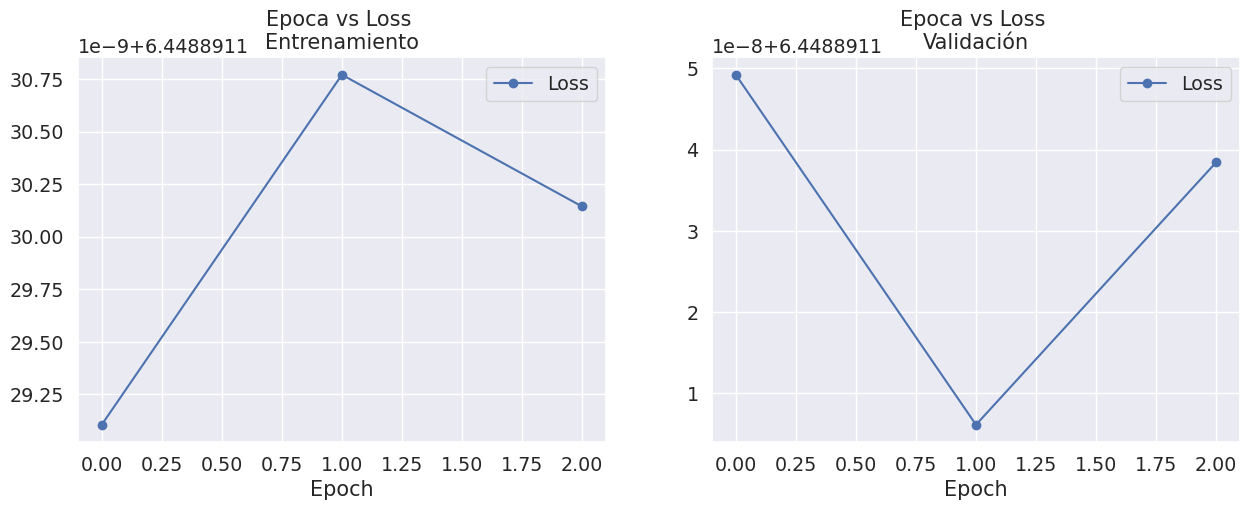

In [40]:
# f, ax = plt.subplots(1,2, figsize=(15,5))

# data.loc[data.Conjunto=='Entrenamiento', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[0],
#                                      kind='line',marker='o',title='Epoca vs Loss \nEntrenamiento')
# data.loc[data.Conjunto=='Validación', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[1],
#                                                         kind='line',marker='o',title='Epoca vs Loss \nValidación')
# plt.show()

La anterior, fue realizada a manera de prueba para ir afinando los hiper parametros, cabe resaltar que en este punto se procesaron los conjuntos de datos por separado, esto se modifico para las pruebas siguientes.


# Prueba 2:

In [ ]:
EPOCHS = 5
FILTERS_COUNT = [100,100,100] #num_filters
FILTERS_LENGTH = [2, 3, 4] #filter_sizes

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))

train_loader = DataLoader(train_ds, batch_size=300, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=12)

dev_loader = DataLoader(dev_ds, batch_size=300, shuffle=True,
                         collate_fn=pad_sequences, drop_last=False, num_workers=12)

test_loader = DataLoader(test_ds, batch_size=300, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=12)

In [28]:
from sklearn import metrics

mlflow.set_experiment("Experimento_3_CNN")

with mlflow.start_run():
    mlflow.log_param("model_name", "CNN")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
#         "fc_size": 100
    })
    
    cnn = CNN("./data/SBW-vectors-300-min5.txt.bz2",
              preprocess_train.dictionary, 
              vector_size=300,
              freeze_embedings=True,
              num_filters=[100,100,100],
              filter_sizes=[2, 3, 4],
              num_classes=632,
              dropout=0.3)
    
    cnn.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-4, weight_decay=1e-5)
    
    historyCNN2 = {'val_loss': [],
               'train_loss': [],
               'total_accuracy': []
              }       
    
    
    for epoch in trange(EPOCHS):
        cnn.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long()
            labels = labels.to(device)
            
            
            outputs = cnn(inputs)

            loss_value = loss_function(outputs, labels)

            loss_value.backward()
            optimizer.step()
            
            running_loss.append(loss_value.item())         
        
        
        longitud_vec = len(running_loss)
        sumatoria_vec = sum(running_loss)
            
        mlflow.log_metric("train_loss", sumatoria_vec/longitud_vec, epoch)
        historyCNN2['train_loss'].append((sumatoria_vec/longitud_vec, epoch))
        
        # Controlamos las metricas dentro de las epocas
        print(f'Epoca: {epoch}')
        print(f'\nPerdida-loss: {sumatoria_vec/longitud_vec}')
        
        cnn.eval()
        
        running_loss_dev = []
        targets = []
        predictions = []
        
        for i, data in enumerate(tqdm(dev_loader)):
            
            inputs_v = data["data"].to(device)
            labels_v = data["target"].squeeze().long()
            labels_v = labels_v.to(device)            
            output = cnn(inputs_v)
            
            running_loss_dev.append(loss_function(output, labels_v).item())
            _, predicted = torch.max(output.data, 1)
            
            targets.extend(labels_v.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
        mlflow.log_metric("val_loss", sum(running_loss_dev) / len(running_loss_dev), epoch)
        mlflow.log_metric("total_accuracy", balanced_accuracy_score(targets, predictions), epoch)
        
        historyCNN2['val_loss'].append((sum(running_loss_dev) / len(running_loss_dev), epoch))
        historyCNN2['total_accuracy'].append((balanced_accuracy_score(targets, predictions), epoch))
       
        print(f'Perdida-loss/validacion: {sum(running_loss_dev)/len(running_loss_dev)}')
        print(f'total_accuracy: {balanced_accuracy_score(targets, predictions)}')

                

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16318 [00:00<?, ?it/s]

Epoca: 0

Perdida-loss: 6.396692449576949


  0%|          | 0/213 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.411257790847563
val_avp: 0.03957615676026831


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoca: 1

Perdida-loss: 6.397661059901241


  0%|          | 0/213 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.414051026805466
val_avp: 0.03692819676595775


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoca: 2

Perdida-loss: 6.394919151417661


  0%|          | 0/213 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.408948193133717
val_avp: 0.04195875495512363


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoca: 3

Perdida-loss: 6.393620598446229


  0%|          | 0/213 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.41017541079454
val_avp: 0.040769906765774216


  0%|          | 0/16318 [00:00<?, ?it/s]

Epoca: 4

Perdida-loss: 6.392230534118127


  0%|          | 0/213 [00:00<?, ?it/s]

Perdida-loss/validacion: 6.407981366618698
val_avp: 0.04290172246370668


In [29]:
print(cnn)


CNN(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
  )
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=632, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=632, out_features=632, bias=True)
)


In [30]:
historyCNN2

{'val_loss': [(6.411257790847563, 0),
  (6.414051026805466, 1),
  (6.408948193133717, 2),
  (6.41017541079454, 3),
  (6.407981366618698, 4)],
 'train_loss': [(6.396692449576949, 0),
  (6.397661059901241, 1),
  (6.394919151417661, 2),
  (6.393620598446229, 3),
  (6.392230534118127, 4)],
 'total_accuracy': [(0.03957615676026831, 0),
  (0.03692819676595775, 1),
  (0.04195875495512363, 2),
  (0.040769906765774216, 3),
  (0.04290172246370668, 4)]}

In [31]:

mlflow.search_runs()
runs = mlflow.search_runs()
runs[runs.status == "FINISHED"]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_avp,metrics.train_loss,metrics.val_loss,params.filters_length,params.filters_count,params.model_name,params.freeze_embedding,params.fc_size,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
0,9d03b256e3124fceaea97c8a9dd3445f,6,FINISHED,file:///users/dfonnegra/mlruns/6/9d03b256e3124...,2022-11-11 12:28:06.404000+00:00,2022-11-11 12:56:36.201000+00:00,0.042902,6.392231,6.407981,"[2, 3, 4]","[100, 100, 100]",CNN,True,None,zealous-auk-897,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
4,c84c315fc117455cb7b8f535696b7406,6,FINISHED,file:///users/dfonnegra/mlruns/6/c84c315fc1174...,2022-11-11 00:06:46.177000+00:00,2022-11-11 00:48:57.387000+00:00,0.001582,6.448891,6.448891,"[3, 4, 5]","[100, 100, 100]",CNN,True,None,funny-bass-207,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
8,535d783cf93d4ba98248e909dd6d5d82,6,FINISHED,file:///users/dfonnegra/mlruns/6/535d783cf93d4...,2022-11-10 22:50:59.404000+00:00,2022-11-10 23:17:30.121000+00:00,0.001582,6.448891,6.448891,"[3, 4, 5]","[100, 100, 100]",CNN,True,None,suave-hare-243,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
9,00b3c710c87144d38f392f82ea225bf4,6,FINISHED,file:///users/dfonnegra/mlruns/6/00b3c710c8714...,2022-11-10 22:00:33.990000+00:00,2022-11-10 22:50:04.123000+00:00,0.001582,6.448891,6.448891,"[3, 4, 5]","[100, 100, 100]",CNN,True,None,polite-skunk-12,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
29,8235a004247f42d4910dc59b6b7500a0,6,FINISHED,file:///users/dfonnegra/mlruns/6/8235a004247f4...,2022-11-02 22:48:33.375000+00:00,2022-11-03 00:04:52.868000+00:00,0.001582,0.000000,0.000000,"[2, 3, 4]",100,CNN,True,100,fearless-moose-556,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
36,771ceaed6535429b97cc99d5e00d71c7,6,FINISHED,file:///users/dfonnegra/mlruns/6/771ceaed65354...,2022-11-02 18:07:46.090000+00:00,2022-11-02 19:38:39.829000+00:00,0.001582,-31225.488365,-31225.731217,"[2, 3, 4]",100,CNN,True,100,carefree-hen-512,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra
42,b981782399394982ad4221e396292ed9,6,FINISHED,file:///users/dfonnegra/mlruns/6/b981782399394...,2022-11-02 16:50:43.381000+00:00,2022-11-02 17:31:38.797000+00:00,0.001582,-31225.233430,-31225.671243,"[2, 3, 4]",100,CNN,True,50,awesome-slug-429,LOCAL,/users/dfonnegra/miniconda3/envs/deeplearning/...,dfonnegra


In [32]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        historyCNN2['train_loss'], historyCNN2['val_loss'])):
    print((epoch, 'Entrenamiento', train_loss[0]))
    print((epoch, 'Validación', val_loss[0]))
    data.append((epoch, 'Entrenamiento', train_loss[0]))
    data.append((epoch, 'Validación', val_loss[0]))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'Loss'])

(0, 'Entrenamiento', 6.396692449576949)
(0, 'Validación', 6.411257790847563)
(1, 'Entrenamiento', 6.397661059901241)
(1, 'Validación', 6.414051026805466)
(2, 'Entrenamiento', 6.394919151417661)
(2, 'Validación', 6.408948193133717)
(3, 'Entrenamiento', 6.393620598446229)
(3, 'Validación', 6.41017541079454)
(4, 'Entrenamiento', 6.392230534118127)
(4, 'Validación', 6.407981366618698)


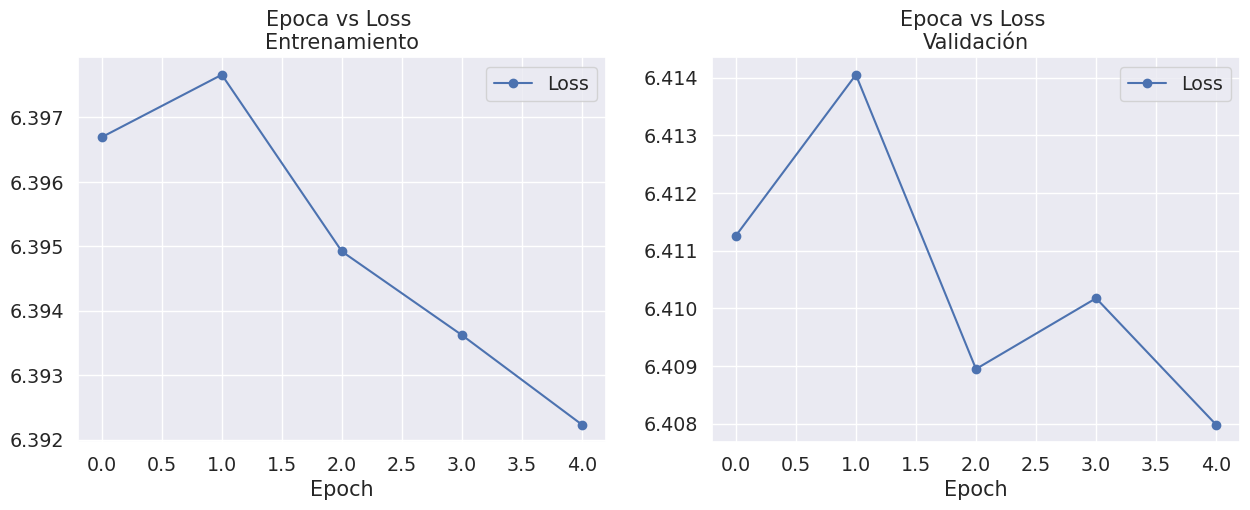

In [33]:
f, ax = plt.subplots(1,2, figsize=(15,5))

data.loc[data.Conjunto=='Entrenamiento', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[0],
                                     kind='line',marker='o',title='Epoca vs Loss \nEntrenamiento')
data.loc[data.Conjunto=='Validación', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[1],
                                                        kind='line',marker='o',title='Epoca vs Loss \nValidación')
plt.show()

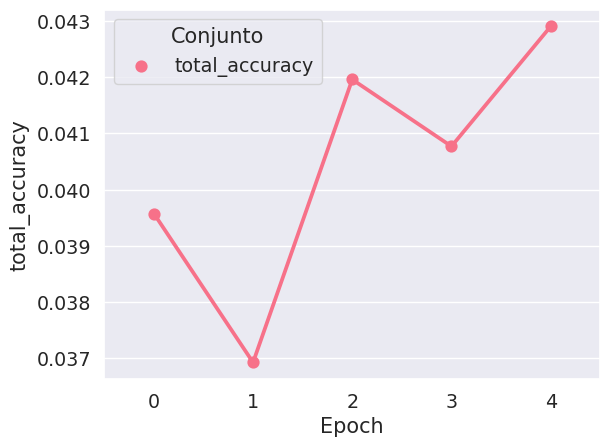

In [35]:
data = []
for total_accuracy,epoch in historyCNN2['total_accuracy']:
    data.append((epoch,'total_accuracy',total_accuracy))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'total_accuracy'])
sns.pointplot(
    data=data, x='Epoch', y='total_accuracy', hue='Conjunto', palette='husl')
plt.show()

La anterior muestra que el modelo propuesto muestra que la red esta aprendiendo aunque lo hace de forma lenta, es por esto que se buscara realizar una prueba con un mayor numero de epocas para asi ver tanto el comportamiento de la loss vs epocas como de la accuracy.

# Prueba 3

La siguiente no presento registro de ejecucion (problemas con nabu) :(
Sin embargo mientras ejecutamos vimos que presentaba una mejora en las metricas y una tendencia similar en las curvas de loss vs epocas, es por ello que dejamos evidencia de lo que intentamos desarrollar... :)

In [ ]:
EPOCHS = 30
FILTERS_COUNT = [100,100,100] #num_filters
FILTERS_LENGTH = [2, 3, 4] #filter_sizes

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))

train_loader = DataLoader(train_ds, batch_size=300, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=12)

dev_loader = DataLoader(dev_ds, batch_size=300, shuffle=True,
                         collate_fn=pad_sequences, drop_last=False, num_workers=12)

test_loader = DataLoader(test_ds, batch_size=300, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=12)

In [ ]:
from sklearn import metrics

mlflow.set_experiment("Experimento_3_CNN")

with mlflow.start_run():
    mlflow.log_param("model_name", "CNN")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
#         "fc_size": 100
    })
    
    cnn = CNN("./data/SBW-vectors-300-min5.txt.bz2",
              preprocess_train.dictionary, 
              vector_size=300,
              freeze_embedings=True,
              num_filters=[100,100,100],
              filter_sizes=[2, 3, 4],
              num_classes=632,
              dropout=0.3)
    
    cnn.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=1e-5, weight_decay=1e-5)
    
    historyCNN3 = {'val_loss': [],
               'train_loss': [],
               'total_accuracy': []
              }       
    
    
    for epoch in trange(EPOCHS):
        cnn.train()
        running_loss = []
        
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            inputs = batch["data"].to(device)
            labels = batch["target"].squeeze().long()
            labels = labels.to(device)
            
            
            outputs = cnn(inputs)

            loss_value = loss_function(outputs, labels)

            loss_value.backward()
            optimizer.step()
            
            running_loss.append(loss_value.item())         
        
        
        longitud_vec = len(running_loss)
        sumatoria_vec = sum(running_loss)
            
        mlflow.log_metric("train_loss", sumatoria_vec/longitud_vec, epoch)
        historyCNN3['train_loss'].append((sumatoria_vec/longitud_vec, epoch))
        
        # Controlamos las metricas dentro de las epocas
        print(f'Epoca: {epoch}')
        print(f'\nPerdida-loss: {sumatoria_vec/longitud_vec}')
        
        cnn.eval()
        
        running_loss_dev = []
        targets = []
        predictions = []
        
        for i, data in enumerate(tqdm(dev_loader)):
            
            inputs_v = data["data"].to(device)
            labels_v = data["target"].squeeze().long()
            labels_v = labels_v.to(device)            
            output = cnn(inputs_v)
            
            running_loss_dev.append(loss_function(output, labels_v).item())
            _, predicted = torch.max(output.data, 1)
            
            targets.extend(labels_v.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            
        
        mlflow.log_metric("val_loss", sum(running_loss_dev) / len(running_loss_dev), epoch)
        mlflow.log_metric("total_accuracy", balanced_accuracy_score(targets, predictions), epoch)
        
        historyCNN3['val_loss'].append((sum(running_loss_dev) / len(running_loss_dev), epoch))
        historyCNN3['total_accuracy'].append((balanced_accuracy_score(targets, predictions), epoch))
       
        print(f'Perdida-loss/validacion: {sum(running_loss_dev)/len(running_loss_dev)}')
        print(f'total_accuracy: {balanced_accuracy_score(targets, predictions)}')

                        

In [ ]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(
        historyCNN3['train_loss'], historyCNN3['val_loss'])):
    print((epoch, 'Entrenamiento', train_loss[0]))
    print((epoch, 'Validación', val_loss[0]))
    data.append((epoch, 'Entrenamiento', train_loss[0]))
    data.append((epoch, 'Validación', val_loss[0]))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'Loss'])

In [ ]:
f, ax = plt.subplots(1,2, figsize=(15,5))

data.loc[data.Conjunto=='Entrenamiento', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[0],
                                     kind='line',marker='o',title='Epoca vs Loss \nEntrenamiento')
data.loc[data.Conjunto=='Validación', ['Epoch', 'Loss']].plot(x='Epoch', y='Loss', ax=ax[1],
                                                        kind='line',marker='o',title='Epoca vs Loss \nValidación')
plt.show()

In [ ]:
data = []
for total_accuracy,epoch in historyCNN3['total_accuracy']:
    data.append((epoch,'test_avp',total_accuracy))
data = pd.DataFrame(data=data, columns=['Epoch', 'Conjunto', 'total_accuracy'])
sns.pointplot(
    data=data, x='Epoch', y='test_avp', hue='Conjunto', palette='husl')
plt.show()

# Conclusiones:

A nivel general, sobre el conjunto de datos realizamos un preprocesamiento de los datos:
1. Concatenamos los conjuntos de datos y a estos se les suministraban a preprocess_test = RawDataProcessor(data), para despues transformar los conjuntos de entrenamiento validacion y prueba con el mismo.

2. Se implementaron 2 ejemplos Redes neuronales CNN, para el procesamiento de texto, que presentaban diferencias en cuanto a su estructura.  Cambiamos algunos hiper-parametros como (longitud de los filtros, epocas, tamaño del batch, num_workers, y las tasas de aprendizaje). De ambos experimentos podemos inferir que el modelo con mejor rendimiento fue el mostrado en la prueba 2, el cual se constituia de la siguiente forma:

`
CNN(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
  )
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=632, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=632, out_features=632, bias=True)
)
`
- Ademas, el modelo presentaba en la capa de salida la funcion `Softmax`  (como nos sugirio el profesor Mauricio), la cual es util para clasificaciones multiclase, dado que transforma los datos a una distribucion de probabilidad. También, para evaluar el error se utilizó `CrossEntropyLoss`.

- Asimismo, dentro de las redes ejecutadas cambiamos algunos hiper-parametros como (longitud de los filtros, epocas tamaño del batch, num_workers, y las tasas de aprendizaje).

- Consideramos que la red presenta una perdida lenta debido a lo mostrado en los graficos de perdida vs epocas, y el crecimiento de la metrica evaluada. Esto puede indicar una necesidad de modificar a la estructura e hiperparametros, o dar espacio a muchas mas epocas (+1000) para que la red analice a la informacion, esto ultimo basandonos en la tendencia y valores que presentan las curvas.



### Nota:

- Se trato de implementar la prueba #3 pero no se logro guardar el resultado, debido a problematicas relacionadas al nabu, sin embargo se noto hasta la 8 epoca que presentaba una tendencia similar a la red 2. Cabe mencionar que este intento presentaba un cambio en cuanto a la tasa de aprendizaje (era mucho mas pequeña).